# Hartmann function

**Goal**: apply Bayesian Optimisation (BO) strategy to minimize Hartmann function with pyro.

In [23]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.enable_validation(True)

In [2]:
print("torch:", torch.__version__)
print("pyro:", pyro.__version__)

if not pyro.__version__.startswith("1"):
    raise ValueError("incompatible version of pyro")

torch: 1.3.0.post2
pyro: 1.0.0


In [3]:
seed_number = 444

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_random_seed(seed_number)

## Objective function

In [5]:
const_hf_a = torch.tensor([[10.0, 3.0, 17.0, 3.5, 1.7, 8.0],
                           [0.05, 10.0, 17.0, 0.1, 8.0, 14.0],
                           [3.0, 3.5, 1.7, 10.0, 17.0, 8.0],
                           [17.0, 8.0, 0.05, 10.0, 0.1, 14.0]])

const_hf_c = torch.tensor([1.0, 1.2, 3.0, 3.2])

const_hf_p = torch.tensor([[0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886], 
                           [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
                           [0.2348, 0.1451, 0.3522, 0.2883, 0.3047, 0.6650],
                           [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381]])

def hartmann_func(x):
    """
    Compute Hartmann function
    Args:
        x - [N, 6] dimensional torch tensor.
    Returns:
        function value
    """
    
    no_dims = x.shape[0]
    
    result = torch.zeros((no_dims))
    
    for d in range(no_dims):
                
        for i in range(4):            
            sm = torch.dot(const_hf_a[i], (x[d] - const_hf_p[i])**2)
        
            result[d] += const_hf_c[i]*torch.exp(-sm)
            
    return -result

# Checking GM
assert np.allclose(
        hartmann_func(torch.tensor([[0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]])).numpy(),
        np.array([-3.32237], dtype=np.float32))

# Constructing BO strategy

### Defining acquisition function

In [6]:
def lower_confidence_bound(gpmodel, x, kappa=2):
    """
    Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$
    
    """
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(gpmodel, x):
    """
    Brooks' implementation of expected improvement (EI).
    
    """
    y_min = gpmodel.y.min()
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    
    sigma = variance.sqrt()
    
    delta = y_min - mu
    
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(gpmodel, x, af='EI'):
    """
    Defines acquisition function.
    """
    
    if af == "EI":
        return expected_improvement(gpmodel, x)
    
    elif af == "LCB":
        return lower_confidence_bound(gpmodel, x)
    
    else:
        return None

## Minimalistic BO Algorithm

### Function to find minimizing points for an acquisition function

In [7]:
def find_a_candidate(gpmodel, x_init):
    
    # Creating constrains
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)
    
    # transform x_init to an unconstrained domain as we use an unconstrained optimizer
    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])
    x_uncon_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser
    minimizer = optim.Adam([x_uncon])

    def closure():
        # clear gradients
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
        x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
        x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
        y = acquisition_func(gpmodel, x)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))
                
        return y
    
    for _ in range(100):
        minimizer.step(closure)
        
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
    x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
    
    return x.detach()

### A single step of BO

LBFGS optimiser used in `find_a_candidate` is a gradient based method and can get stuck at a local minimum. A simple approach to address this is to try several attemps (5) to find the best candidate to minimize the acquisition function.

In [8]:
def next_x(gpmodel, num_candidates=5):
    
    candidates = []
    values = []
    
    # take the best (lowest) point as the first attempt
    x_init = gpmodel.X[[gpmodel.y.argmin()], :].detach().requires_grad_(True)
        
    for i in range(num_candidates):
        
        x = find_a_candidate(gpmodel, x_init)
        y = acquisition_func(gpmodel, x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
    
        print("Candidate ", i, x, y)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    print("Result: ", candidates[argmin], values[argmin])
    
    return candidates[argmin], candidates

### Updating posterior

Each time we evaluate `f` at a new value x, we update the `gpmodel`.

In [11]:
def update_posterior(gpmodel, x_new, svi_mode=False):
        
    # evaluate f at new point
    bh_y = hartmann_func(x_new) 
    
    # incorporate new evaluation
    X = torch.cat([gpmodel.X, x_new]) 
    y = torch.cat([gpmodel.y, bh_y])
        
    gpmodel.set_data(X, y)
    
    # optimising hyper paramters
    
    optimiser = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    
    if svi_mode:
        loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
        gp.util.train(gpmodel, optimiser, loss_fn, num_steps=2000)
    else:
        gp.util.train(gpmodel, optimiser) 

# Training data

In [21]:
x_min = 0
x_max = 1

train_cnt = 10

X_train = torch.rand(train_cnt, 6)
Y_train = hartmann_func(X_train)

# Deterministic approach

In [76]:
set_random_seed(333)

gp_model = gp.models.GPRegression(X_train, Y_train, 
    gp.kernels.Matern52(input_dim=3, lengthscale=torch.ones(3)))

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.001)
losses = gp.util.train(gp_model, optimizer);

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1
     Trace Shapes:  
      Param Sites:  
kernel.lengthscale 2
     Sample Sites:  

In [73]:
sorted(list(gp_model.named_pyro_params()))

[('kernel.lengthscale', tensor([2.2204, 2.1582], grad_fn=<AddBackward0>)),
 ('kernel.variance', tensor(0.4145, grad_fn=<AddBackward0>)),
 ('noise', tensor(0.1215, grad_fn=<AddBackward0>))]

In [36]:
# bo_steps = 10

# for i in range(bo_steps):
#     print("-"*50)
#     print("BO STEP: ", i)
#     print("-"*50)
    
#     gp_model_ = copy.copy(gp_model)
    
#     xmin, xcans = next_x(gp_model)
    
#     update_posterior(gp_model, xmin)
        
#     # visualising the step
#     visualise_step(gp_model_, xcans, gp_model)

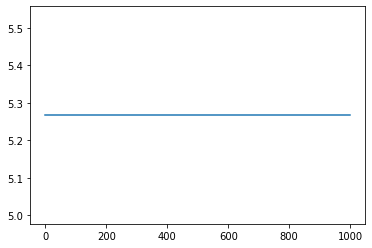

In [74]:
plt.plot(losses)